In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from PIL import Image
import os
import warnings

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
from collections import namedtuple
Label = namedtuple( 'Label' , [
    'name','id', 'trainId','category', 
    'categoryId', 
    'hasInstances',
    'ignoreInEval', 
    'color', 
    ] )
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [ ]:
N_FILTERS = 64
KERNEL_SIZE = 3
N_CLASSES = len(labels)
IMAGE_SIZE = [128, 128]
IMAGE_SHAPE = IMAGE_SIZE + [3,]
EPOCHS = 40
BATCH_SIZE = 32
MODEL_CHECKPOINT_FILEPATH = './mod1res.weights.h5'
id2color = { label.id : np.asarray(label.color) for label in labels }

In [ ]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)
    image = np.array(image) / 255 
    mask = np.array(mask) 
    return image, mask

def find_closest_labels_vectorized(mask, mapping):
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   
    for id, color in mapping.items(): 
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    return closest_category

In [ ]:
train_filepath = 'C:/Users/vagis/Downloads/segmentation/archive/cityscapes_data/train'
val_filepath = 'C:/Users/vagis/Downloads/segmentation/archive/cityscapes_data/val'


train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath +"/"+ train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, id2color))
    
for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_filepath +"/"+ val_file, IMAGE_SIZE)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(find_closest_labels_vectorized(mask, id2color))

Building Validation Dataset: 100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


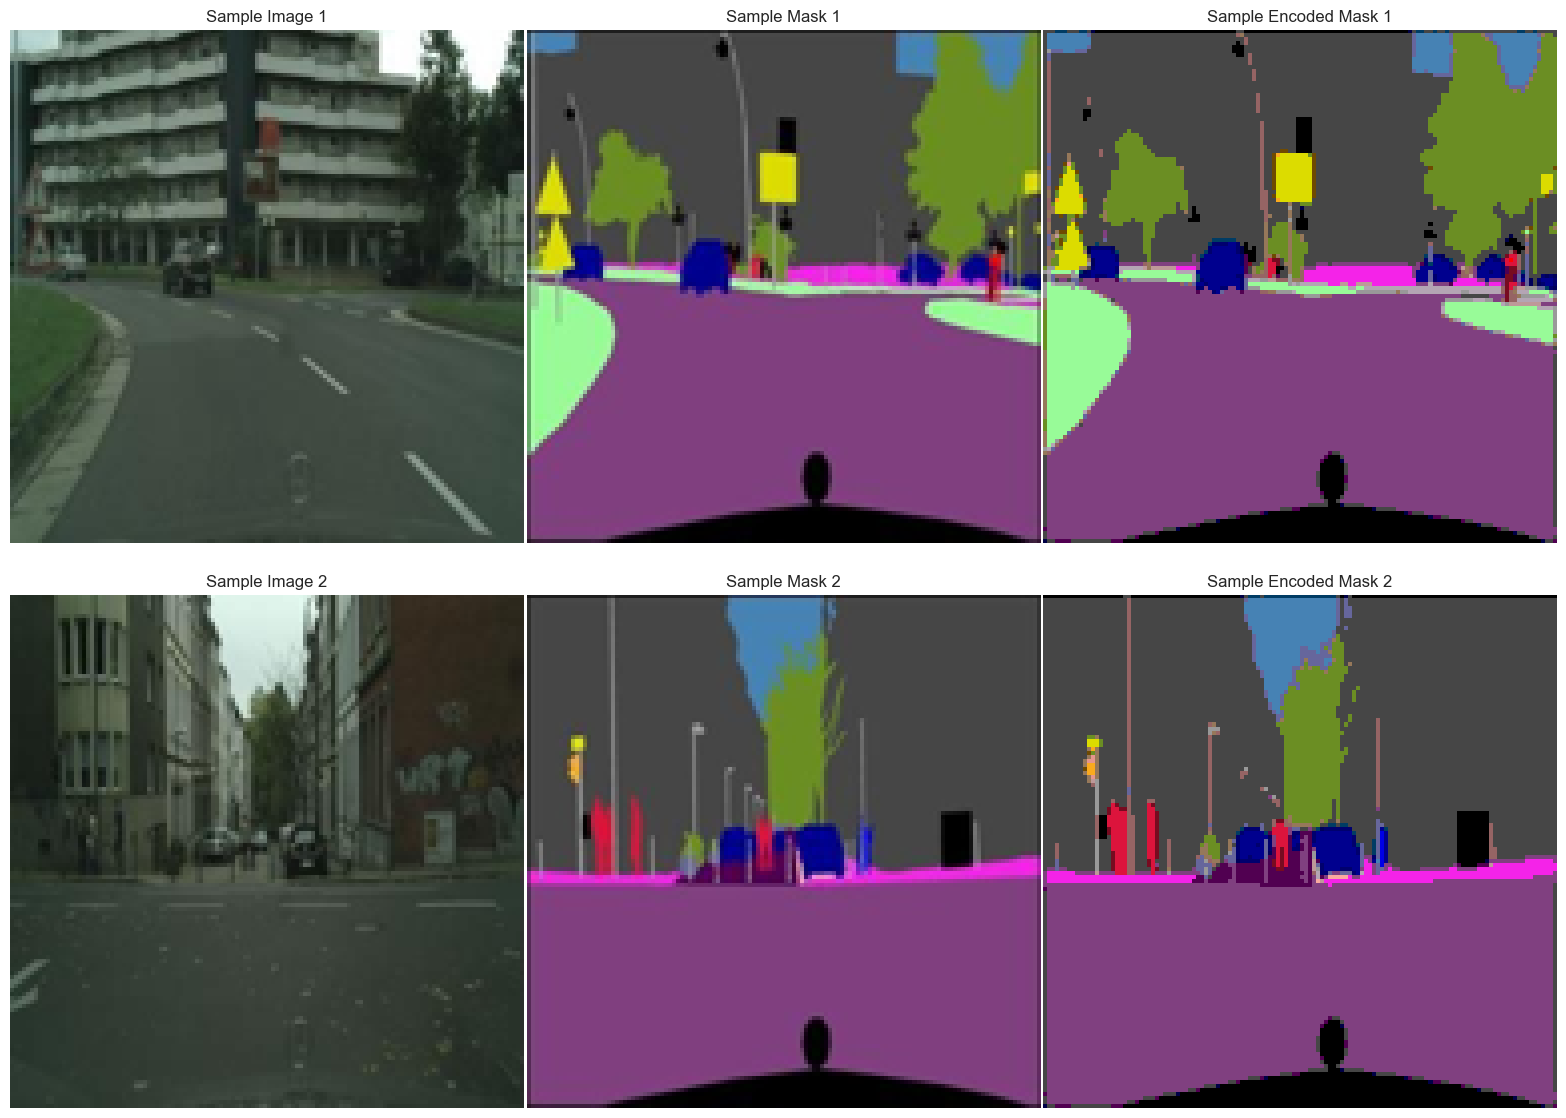

In [10]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
            
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [ ]:
# delete the masks as they are no longer needed to free up RAM
del train_masks, val_masks

In [11]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply

def squeeze_excite_block(input_tensor, ratio=32):
    channel_axis = -1  
    filters = input_tensor.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape([1, 1, filters])(se)
    se = Multiply()([input_tensor, se])
    return se


In [39]:
from tensorflow.keras.layers import AveragePooling2D, UpSampling2D, Concatenate

def pyramid_pooling_module(input_tensor, filters, pool_sizes=[1, 2, 3, 6]):
    pooled_features = [input_tensor]
    for size in pool_sizes:
        # Apply AveragePooling with different pool sizes
        pooled = AveragePooling2D(pool_size=(size, size))(input_tensor)
        # Upsample to match the input tensor's spatial dimensions
        upsampled = UpSampling2D(size=(input_tensor.shape[1] // pooled.shape[1], 
                                       input_tensor.shape[2] // pooled.shape[2]))(pooled)
        pooled_features.append(upsampled)
    # Concatenate all pooled features
    return Concatenate()(pooled_features)


In [31]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout

def conv_block(inputs=None, n_filters=32, kernel_size=3, dropout_prob=0, max_pooling=True, use_se=True):
    # Apply first convolution
    conv = Conv2D(n_filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    # Apply second convolution
    conv = Conv2D(n_filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    # Apply squeeze and excite block if specified
    if use_se:
        conv = squeeze_excite_block(conv)
    
    # Apply dropout if specified
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    # Apply max pooling if specified, and set next_layer
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
    
    # Set skip connection
    skip_connection = conv
    
    return next_layer, skip_connection


def upsampling_block(expansive_input, contractive_input, n_filters=32, kernel_size = 3):
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size = kernel_size,    # Kernel size
                 strides = (2,2),
                 padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size = (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size = (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D, concatenate


def build_resnet_se_model_with_ppm(input_shape, n_classes):
    # Load ResNet backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze ResNet layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Define input layer
    inputs = base_model.input
    
    # Bottleneck with Pyramid Pooling Module
    bottleneck = base_model.get_layer('conv4_block6_out').output
    ppm = pyramid_pooling_module(bottleneck, filters=256)
    
    # Decoder part with SE blocks and UpSampling
    x = conv_block(ppm, n_filters=256, use_se=True)
    x = UpSampling2D()(x)
    x = concatenate([x, base_model.get_layer('conv3_block4_out').output])
    
    x = conv_block(x, n_filters=128, use_se=True)
    x = UpSampling2D()(x)
    x = concatenate([x, base_model.get_layer('conv2_block3_out').output])
    
    x = conv_block(x, n_filters=64, use_se=True)
    x = UpSampling2D()(x)
    x = concatenate([x, base_model.get_layer('conv1_conv').output])
    
    x = conv_block(x, n_filters=32, use_se=True)
    x = UpSampling2D()(x)
    
    # Final convolution layer to get desired output classes
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(x)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


    

In [ ]:
# use the functions to build the model and display it below
model = build_resnet_se_model_with_ppm(IMAGE_SHAPE, N_FILTERS, KERNEL_SIZE, N_CLASSES)



In [43]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = callbacks)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2763 - loss: 2.9513 
Epoch 1: val_accuracy improved from -inf to 0.44182, saving model to ./mod1res.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2000s 21s/step - accuracy: 0.2768 - loss: 2.9465 - val_accuracy: 0.4418 - val_loss: 1.9345
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5530 - loss: 1.5967 
Epoch 2: val_accuracy improved from 0.44182 to 0.66419, saving model to ./mod1res.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1585s 17s/step - accuracy: 0.5536 - loss: 1.5944 - val_accuracy: 0.6642 - val_loss: 1.2132
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7001 - loss: 1.0770 
Epoch 3: val_accuracy improved from 0.66419 to 0.69696, saving model to ./mod1res.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1578s 17s/step - accuracy: 0.7002 - loss: 1.0767 - val_accuracy: 0.6970 - val_loss: 1.0821
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7301 - loss: 0.9806 
Epoch 4: val_accuracy improved

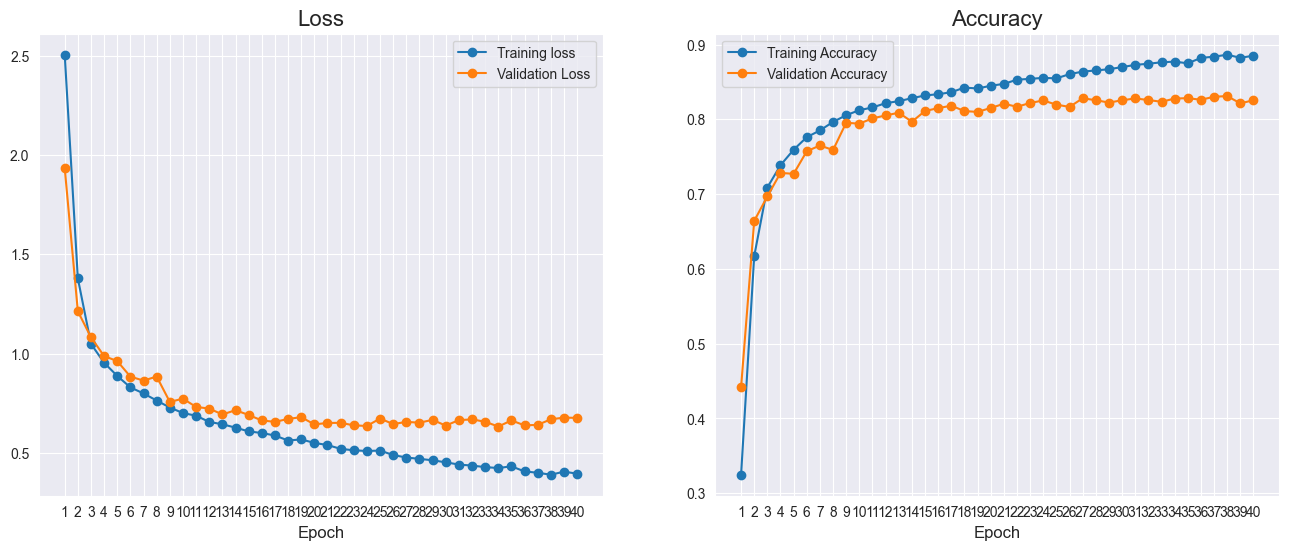

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [ ]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) 
val_loss, val_accuracy = model.evaluate(x = val_images, y = val_masks_enc) 
print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*val_accuracy, 2)) + '\033[0m')

16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8280 - loss: 0.6727

The model had an accuracy score of 83.11%!!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


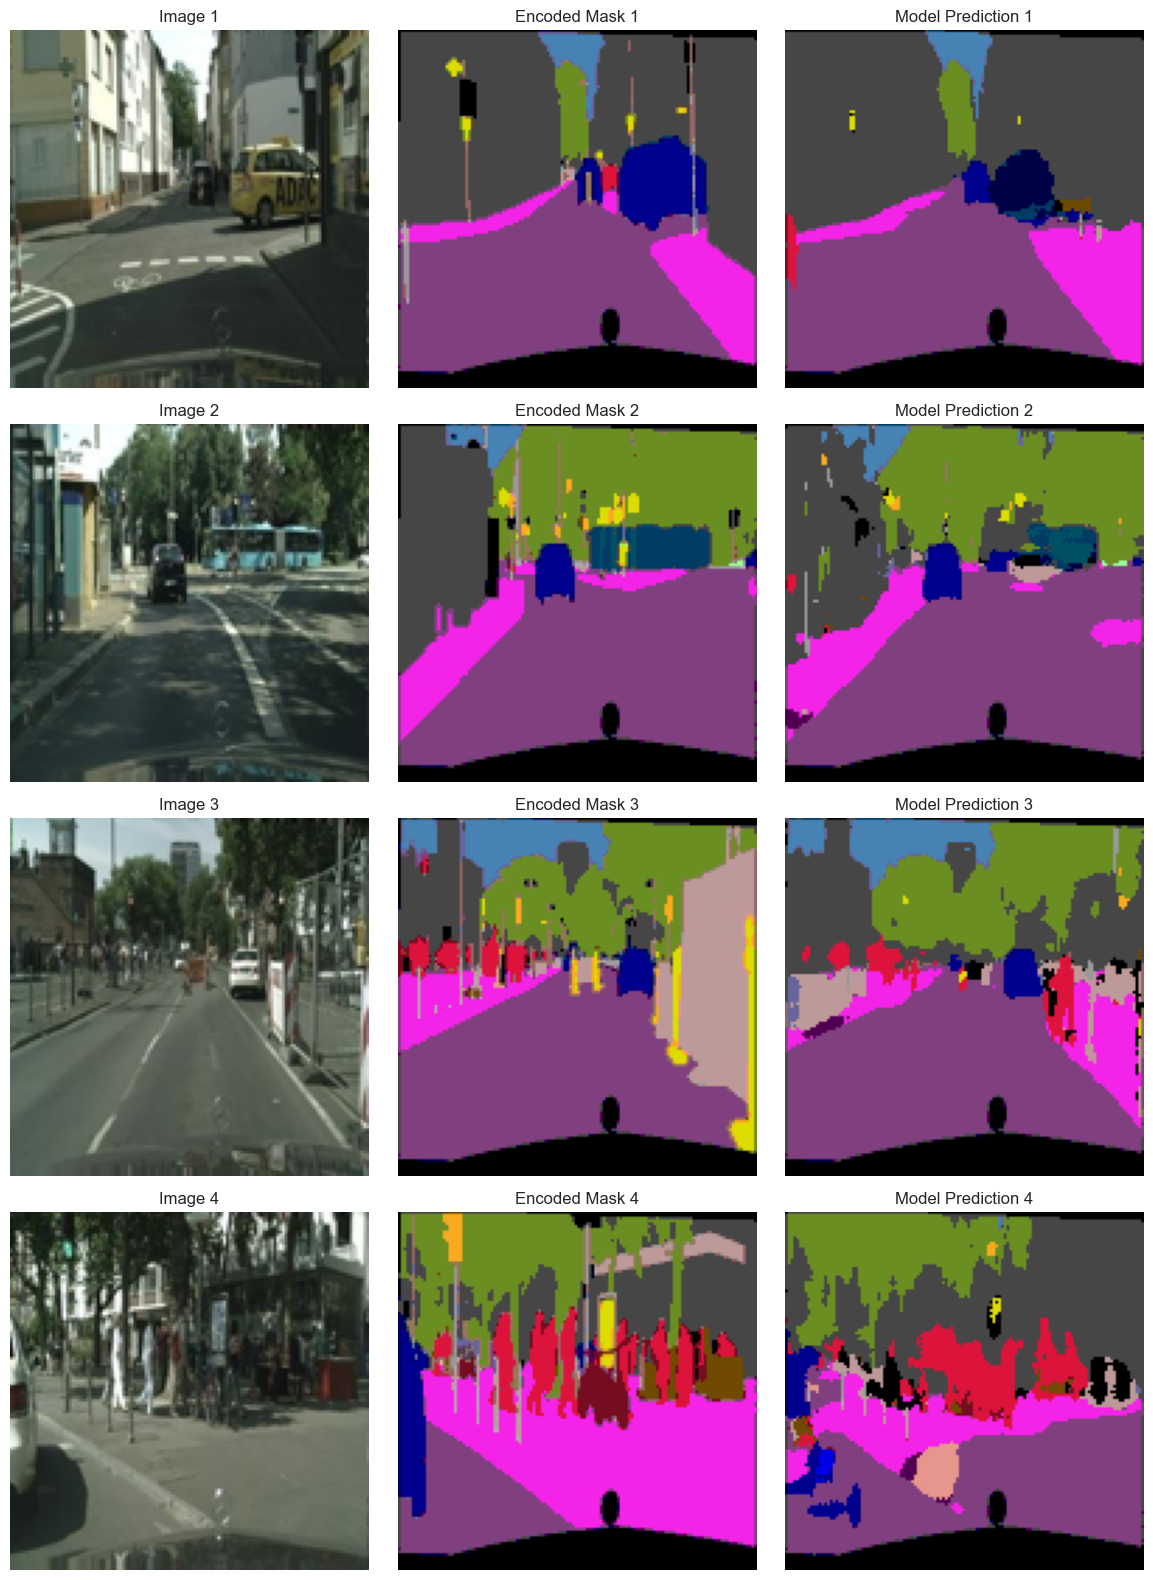

In [46]:
plt.figure(figsize=[15, 20])

for i in range(4):    
    img = val_images[i]
    enc = val_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)